In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import torch

warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

## Load and prepare data

### Raw data

The training data consists of the following sets: 
- 200 keV, 100 ms
- 200 keV, 10 ms
- 60 keV, 100 ms
- 60 keV, 10 ms

1) Import all data points from text files using Pandas

2) Apply a window: the raw spectra are calibrated with their peak around 0 eV loss, but the length of each spectrum differs. Therefore, a window is applied to the input data: it selects the data of all input spectra between [-0.05, 0.05] eV loss 

3) Use 'sklearn.train_test_split' to split the data into training and validation points




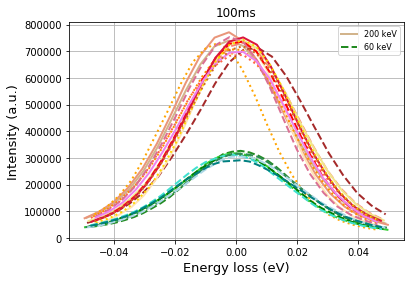

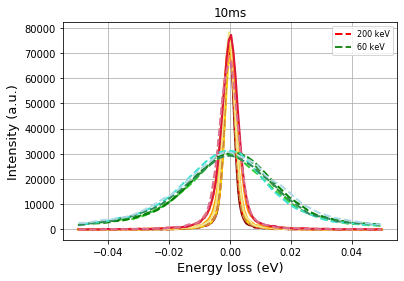

In [15]:
mode = 'Mixture'
%run EELS-ZLP-Mar.py



## Data preprocessing

Unscaled input variables can result in a slow or unstable learning process, whereas unscaled target variables on regression problems can result in exploding gradients causing the learning process to fail. [1]

The energy loss is scaled between [-1, 1] and all input spectra are normalized to the height of one ZLP for 10 ms exposure time. This way, spectra with 10 ms $t_{exp}$ peak around 1 and spectra with 100 ms $t_{exp}$ peak around 10.

### Binning
The discretization technique used to assign mean and standard deviation the data points is called Equal Width Discretization [2]. EWD is a simple discretization method that divides the range of observed values for a feature into k equal sized bins. The intervals are computed by 
 $\Delta E = (E_{max} - E_{min}) / k$. \
 Then, within each energy bin $\Delta E$, the mean and variance of all data points within this bin are determined and returned to the original data points. This way, each data point is a vector $[dE, D_i, \sigma_i]$ where dE is the original energy loss; $D_i$ and $\sigma_i$ are the mean and std of the bin $i$ where this point belongs to.  Note that the number of data points within each bin is not necessarily the same. The minimum and maximum number of data points within each bin can be found in the output.

[1] https://github.com/juanrojochacon/ml-ditp-attp/blob/master/Tutorials/Tutorial2/notebooks/Tutorial2a-NonLinearRegression-GLUON.ipynb

[2] (PDF) Comparative Analysis of Supervised and Unsupervised Discretization Techniques. Available from: https://www.researchgate.net/publication/266058863_Comparative_Analysis_of_Supervised_and_Unsupervised_Discretization_Techniques [accessed Apr 16 2020].


Stored 'energy' (int)
Stored 'time' (int)
Stored 'nbins' (int)
With 60 bins, the minimum number of training points within each bin is 19 and maximum is 32


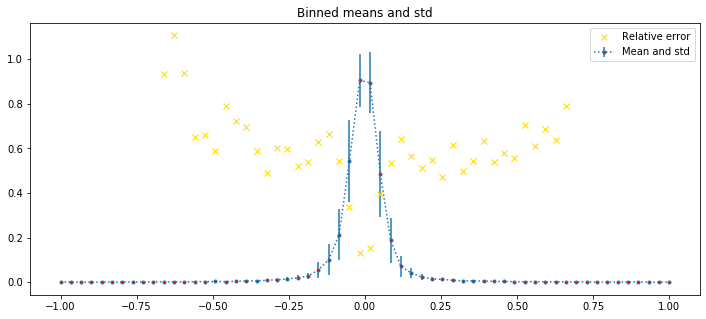

The total number of training datapoints is 1528 and validation points is 656


In [22]:
%run Functions.ipynb
fig = plt.gcf()
from copy import copy

time = 10
energy = 200
nbins = 60
minval = -1
maxval = +1

%store energy
%store time
%store nbins



x_train, y_train, x_val, y_val = prepare_mix_data(time, energy)

# Store output vectors for training
df_train, cuts1_t, cuts2_t = ewd(x_train, y_train)
mean_t, std_t, count_t= binned_statistics(x_train, y_train)
variance_vector_t = vectorize_variance(x_train, y_train)
mean_vector_t = vectorize_mean(x_train, y_train)
#create one vector with (x_train, y_train, sigma_train)
df_train = np.c_[df_train[:,0], mean_vector_t, variance_vector_t]
print("With", nbins, "bins, the minimum number of training points within each bin is", int(min(count_t)), "and maximum is", int(max(count_t)))


# Store output vectors for validation
df_val, cuts1_v, cuts2_v = ewd(x_val, y_val)
mean_v, std_v, count_v= binned_statistics(x_val, y_val)
variance_vector_v = vectorize_variance(x_val, y_val)
mean_vector_v = vectorize_mean(x_val, y_val)
#create one vector with (x_train, y_train, sigma_train)
df_val = np.c_[df_val[:,0], mean_vector_v, variance_vector_v]


### Alternative method: apply smoothing to the signal
N_train = len(df_train[:,0])
N_test = len(df_val[:,0])
smoothing_window_train = 100
smooth_y = np.array(smooth(df_train[:,1], 14))
smooth_y_test = np.array(smooth(df_val[:,1], 14))


# Create a plot of the mean & std 
plot_relative_error(x_train, y_train, nbins, minval, maxval)
plot_uncertainties(x_train, y_train, nbins, minval, maxval)
plt.legend()
fig.set_size_inches(12, 5)
plt.show()

#plot_uncertainties(x_val, y_val, nbins, minval, maxval)
#fig.set_size_inches(12, 5)
#plt.show()



print("The total number of training datapoints is", N_train, "and validation points is", N_test)


## Closure testing

In order to test if the computed error associated to each training point is reasonable, a method called Closure Testing can provide insight.  The 'true' values are then the best Gaussian fit sampled at the energy data of the training points. The parameters of the best fit are determined in the notebook *Gaussian.ipynb* and are fitted to the original data points (before binning).

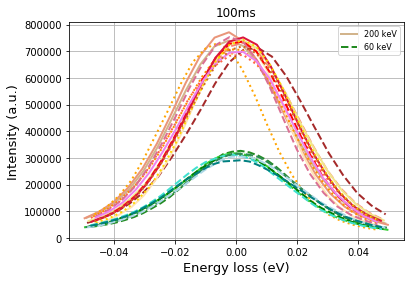

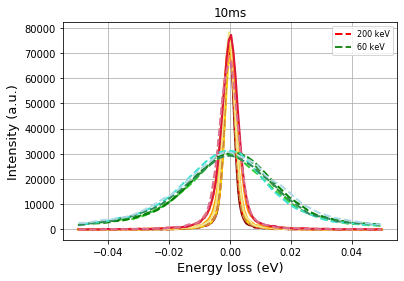

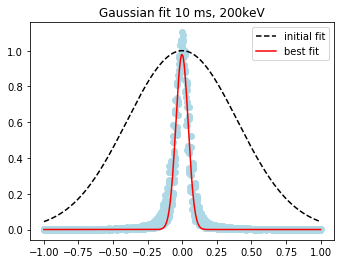

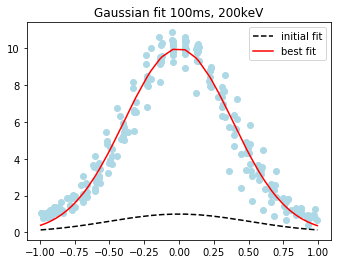

In [185]:
%run Gaussian.ipynb

y_gaus = gaussian(df_train[:,0], amp10, cen10, std10 )

#plt.plot(df_train[:,0], y_gaus, 'o')

## Neural Network 

### Create architecture

In [186]:
def make_model(inputs, n_outputs):

    hidden_layer_1 = tf.layers.dense(inputs, 5, activation=tf.nn.sigmoid)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 5, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dropout(hidden_layer_3, 0.3)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)

    return output



### Prepare data for training

Cost function: $\chi^2 = 1/N \sum (y - y_{pred})^2 / \sigma^2$ \
Optimizer: AdamOptimizer, $\eta = 0.02$\

Training points are generated by Monte Carlo sampling; for the set of training points $[dE, D_i, \sigma_i]$, a set of MC training points is generated by adding a stochastic noise signal on top of the the data with a std equal to the corresponding error on that point. 

- **train_x**: $[dE, t_{exp}]$
- **train_y**: $D_i$ + rand.norm(0, $\sigma_i$)

Repetitive training of the NN (number of repetitions = $N_{rep}$) on each set of MC pseudo data yields a prediction that is distributed with a mean and std corresponding to the mean and error of the original training set. 


In [189]:
tf.reset_default_graph()
from copy import copy

x = tf.placeholder("float", [None, 2])
y = tf.placeholder("float", [None, 1])
sigma = tf.placeholder("float", [None, 1])

N_train = len(df_train[:,0])
N_test = len(df_val[:,0])

predictions = make_model(x,1)

### Define cost and optimizer
cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
eta = 8e-4
optimizer = tf.train.AdamOptimizer(learning_rate=eta, beta1=0.9, beta2=0.999, epsilon=1e-08, ).minimize(cost)

train_x = add_time(df_train, 10)
train_sigma = df_train[:,2].reshape(N_train,1)
test_x = add_time(df_val, 10)
test_sigma = df_val[:,2].reshape(N_test,1)

# Scaling input features to help the minimizer.
train_scaler = StandardScaler()
train_scaler.fit(train_x[:,0].reshape(1,-1))
test_scaler = StandardScaler()
test_scaler.fit(test_x[:,0].reshape(1,-1))

chi_array = []

training_epochs = 50000
max_rising_epochs = 50000 #The amount of epochs the minimzer is allowed to overfit before it stops
display_step = 5000
Nrep = 20
%store Nrep
%store training_epochs

current_conditions = [time, energy, nbins, Nrep, training_epochs]
np.savetxt('Data/Current conditions', current_conditions, delimiter=',')

i = 0


while i < Nrep:
    """Training data: train_y = D_i + rand.norm(0, sigma_i);
    use train_y = gaus_y + rand.norm(0, sigma_i) in case of Closure testing"""
    
    train_y = copy(df_train[:,1]).reshape(N_train,1)  
    train_y += np.random.normal(0, train_sigma) # Create one replica of the training set

    test_y = copy(df_val[:,1]).reshape(N_test,1)
    test_y +=  np.random.normal(0, test_sigma) # Create Monte Carlo points

   
    ### Train and validate

    
    prev_test_cost = 100
    prev_epoch=0
    avg_cost = 0.0
    
    # Use this vector when making a prediction outside range
    predict_xx = np.linspace(-1.5, 1.5, N_train) 
    predict_x = np.c_[predict_xx, 0*predict_xx+1]

    array_train = []
    array_test = []
    
    print("Start training on", '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(training_epochs):

            _, c = sess.run([optimizer, cost], 
                            feed_dict={
                                x: train_x,
                                y: train_y,
                                sigma: train_sigma
                            })
            avg_cost = c 

            test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})


            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
                array_train.append(avg_cost)
                array_test.append(test_cost)

            if test_cost >= prev_test_cost and epoch-prev_epoch >= max_rising_epochs:
                print(colored("\n The session stopped because of overfitting...","red"))
                print("Start overfitting at epoch:", '%04d' % (epoch), "| Validation cost =", "{:.9f}".format(test_cost), "| Train cost=", "{:.9f}".format(avg_cost))
                break
            if avg_cost > 30 and epoch > max_rising_epochs:
                print(colored("\n The session was stuck in a local minimum...", "red"))
                break

            elif test_cost < prev_test_cost:
                prev_test_cost = test_cost
                prev_epoch = epoch


        print("Optimization Finished!")
        predictions_values = sess.run(predictions, 
                            feed_dict={
                                x: train_x,
                                y: train_y 
                            })
    sess.close()

    # save to csv file
    from datetime import datetime
    predictions_values = predictions_values.reshape(N_train,)

    #foot = np.array(seednumber)
    a = np.array(train_x[:,0])
    b = np.array(train_y)
    c = np.array(predictions_values)
    d = array_train
    e = array_test
    
    chi_array.append(d[-1])

    now = datetime.now()
  
    dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
    d_string = now.strftime("%d.%m.%Y")
    t_string = now.strftime("%H:%M:%S")
    
    if d[-1] < 30:
        np.savetxt('Data/Results/%(date)s/xyp_%(energy)s_%(time)sms_e%(epoch)s_%(i)x.csv' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": i }, list(zip(a,b,c)),  delimiter=',',  header="Training inputs, Training outputs, Predictions", fmt='%f')
        np.savetxt('Data/Results/%(date)s/chi_%(energy)s_%(time)sms_e%(epoch)s_%(i)x.csv' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": i }, list(zip(d,e)),  delimiter=',',  header="Chi2_train, Chi2_test", fmt='%f')
    
    print(i)
    i+=1

Start training on 0233 and validating on 0101 samples
Epoch: 0001 | Training cost= 195.033218384 | Validation cost= inf
Epoch: 5001 | Training cost= 48.530448914 | Validation cost= inf
Epoch: 10001 | Training cost= 30.886859894 | Validation cost= inf
Epoch: 15001 | Training cost= 5.989715576 | Validation cost= inf
Epoch: 20001 | Training cost= 1.373801947 | Validation cost= inf
Epoch: 25001 | Training cost= 1.247663617 | Validation cost= inf
Epoch: 30001 | Training cost= 1.222444415 | Validation cost= inf
Epoch: 35001 | Training cost= 1.206391573 | Validation cost= inf
Epoch: 40001 | Training cost= 1.198367476 | Validation cost= inf
Epoch: 45001 | Training cost= 1.188833952 | Validation cost= inf
Optimization Finished!
0
Start training on 0233 and validating on 0101 samples
Epoch: 0001 | Training cost= 137.915786743 | Validation cost= inf
Epoch: 5001 | Training cost= 48.359130859 | Validation cost= inf
Epoch: 10001 | Training cost= 1.283830285 | Validation cost= inf
Epoch: 15001 | Trai

Epoch: 10001 | Training cost= 48.161006927 | Validation cost= inf
Epoch: 15001 | Training cost= 48.129802704 | Validation cost= inf
Epoch: 20001 | Training cost= 48.119430542 | Validation cost= inf
Epoch: 25001 | Training cost= 48.089981079 | Validation cost= inf
Epoch: 30001 | Training cost= 7.307597160 | Validation cost= inf
Epoch: 35001 | Training cost= 1.321395636 | Validation cost= inf
Epoch: 40001 | Training cost= 1.019239664 | Validation cost= inf
Epoch: 45001 | Training cost= 0.999284148 | Validation cost= inf
Optimization Finished!
11
Start training on 0233 and validating on 0101 samples
Epoch: 0001 | Training cost= 165.984313965 | Validation cost= inf
Epoch: 5001 | Training cost= 32.036094666 | Validation cost= inf
Epoch: 10001 | Training cost= 1.103181124 | Validation cost= inf
Epoch: 15001 | Training cost= 0.994037330 | Validation cost= inf
Epoch: 20001 | Training cost= 0.967726171 | Validation cost= inf
Epoch: 25001 | Training cost= 0.963592470 | Validation cost= inf
Epoch

### Plot outputs

Below, the distribution of $\chi^2$ is plotted for training over the $N_{rep}$ MC replicas.

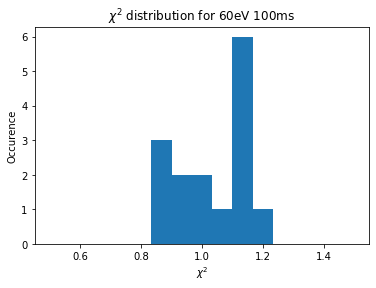

In [192]:
np.savetxt('Data/Results/%(date)s/aaa chidistribution_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.csv' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }, chi_array, delimiter=',', fmt='%f')

plt.hist(chi_array, bins=15, range=[0.5, 1.5])
plt.title('$\chi^2$ distribution for %(energy)seV %(time)sms' % {"energy": energy, "time": time})
plt.xlabel('$\chi^2$')
plt.ylabel('Occurence')
plt.savefig('Data/Results/%(date)s/aaa chidistribution_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep })


plt.show()


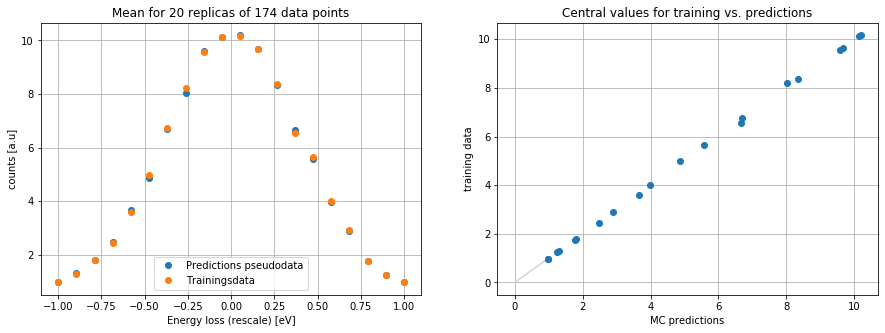

In [197]:
%run Evaluate_pseudodata.ipynb
nbins=20

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('Mean for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
pseudo_xvector = np.linspace(-1,1,nbins)
plt.plot(pseudo_xvector, pseudo_mean, 'o', label = 'Predictions pseudodata')
plt.grid(True)
plt.plot(np.linspace(minval, maxval,  nbins), mean_t, 'o', label='Trainingsdata ')
plt.xlabel(r'Energy loss (rescale) [eV]')
plt.ylabel(r'counts [a.u]')
plt.legend()


plt.subplot(122)
plt.grid(True)
plt.xlabel(r'MC predictions')
plt.ylabel(r'training data')
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='lightgrey')
plt.plot(pseudo_mean, mean_t, 'o')
plt.title('Central values for training vs. predictions')

plt.savefig('Data/Results/%(date)s/aaa means-vs-means_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep })

plt.show()

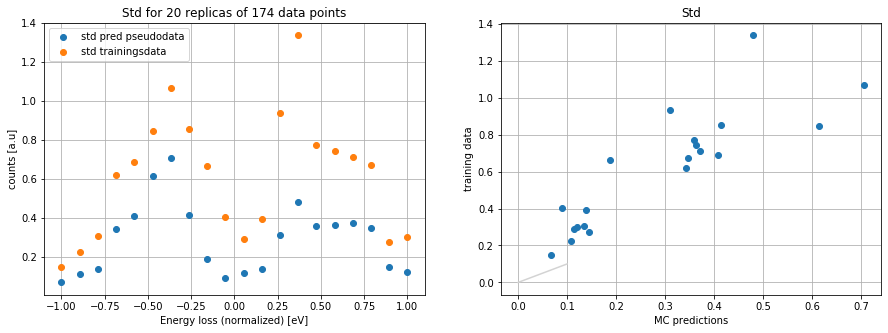

In [198]:
plt.figure(figsize=(15,5))

plt.subplot(121)

plt.plot(pseudo_xvector, pseudo_std, 'o', label = 'std pred pseudodata')
plt.grid(True)
plt.title('Std for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
plt.plot(np.linspace(minval, maxval, nbins), std_t, 'o', label='std trainingsdata ')
plt.xlabel(r'Energy loss (normalized) [eV]')
plt.ylabel(r'counts [a.u]')
plt.legend()

plt.subplot(122)
plt.grid(True)
plt.xlabel(r'MC predictions')
plt.ylabel(r'training data')
plt.plot(np.linspace(0,0.1,10), np.linspace(0,0.1,10), color='lightgrey')
plt.title('Std for training vs. predictions')
plt.plot(pseudo_std, std_t, 'o')
plt.title('Std')

plt.savefig('Data/Results/%(date)s/aaa std-vs-std_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep })

plt.show()

## Residuals

In [201]:
best_res = residuals(best_pred, best_y, df_train[:,2])

ValueError: operands could not be broadcast together with shapes (174,) (233,) 

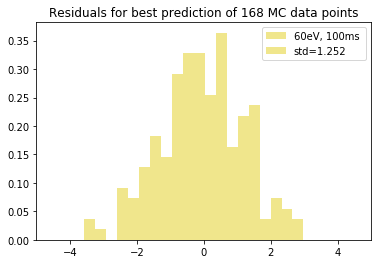

In [177]:
n, bins = np.histogram(best_res, bins=20)

mids = 0.5*(bins[1:] + bins[:-1])
probs = n / np.sum(n)

mean = np.sum(probs * mids)  
sd = np.sqrt(np.sum(probs * (mids - mean)**2))
label1 = r'%(eng)seV, %(time)sms ' % {"eng": energy, "time":time}
label2 = 'std=%(std).5s' % {"std":sd}
plt.hist(best_res, bins=20, density=True, color='khaki', label=label1)
plt.title('Residuals for best prediction of %(N_train)s MC data points' % {"N_train": N_train})
plt.legend([label1, label2])

plt.xlim([-5, 5])
plt.savefig('Data/Results/%(date)s/aaa Residuals_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep })


plt.show()